In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import datamol as dm
import matplotlib.pyplot as plt

All transformers in Molfeat are a subclass of `MoleculeTransformer` which in turns implements the `BaseFeaturizer` interface.
The `BaseFeaturizer` interface ensures that transformers are compatible with both Scikit-Learn and deep learning frameworks, such as PyTorch and DGL.

## Scikit-learn
`MoleculeTransformer` implements the `BaseEstimator` and `TransformerMixin` interfaces from Scikit-Learn. This makes it easy to integrate Molfeat featurizers with Scikit-Learn.
In the example below we create a simple Scikit-learn pipeline to predict the solubility of molecules using a random forest regressor.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from molfeat.trans import MoleculeTransformer

In [3]:
df = dm.data.freesolv()
X, y = df["smiles"], df["expt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# The Molfeat transformer seemingly integrates with Scikit-learn Pipeline!
trans = MoleculeTransformer("desc2d")
pipe = Pipeline([("feat", trans), ("scaler", StandardScaler()), ("rf", RandomForestRegressor())])

In [4]:
with dm.without_rdkit_log():
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    y_pred = pipe.predict(X_test)

print(score)

0.9038476793897086


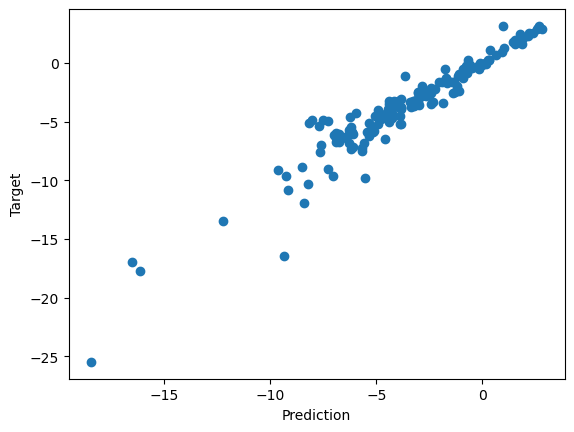

In [5]:
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test)
ax.set_xlabel("Prediction")
ax.set_ylabel("Target");

Molfeat transformers are also compatible with Scikit-Learn's `GridSearchCV`.

In [6]:
from molfeat.trans.fp import FPVecTransformer
from sklearn.model_selection import GridSearchCV

# To search over the featurizer, we use a single transformer that combines several calculators.
feat = FPVecTransformer(kind="rdkit")

param_grid = dict(
    feat__kind=["fcfp:6", "ecfp:6", "maccs"],
    feat__length=[512, 1024],
    rf__n_estimators=[100, 500],
)

pipe = Pipeline([("feat", feat), ("scaler", StandardScaler()), ("rf", RandomForestRegressor(n_estimators=100))])
grid_search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)

with dm.without_rdkit_log():
    grid_search.fit(X_train, y_train)
    score = grid_search.score(X_test, y_test)

score

RuntimeError: Cannot clone object FPVecTransformer(kind="rdkit", length=2000, dtype=np.float32), as the constructor either does not set or modifies parameter length

## PyTorch
The `MoleculeTransformer` also defines some utilities such as the `__len__()` method and the `get_collate_fn()` method which makes it easy to integrate with PyTorch.
In the example below we create a simple PyTorch dataset and dataloader using the Molfeat featurizer.

In [ ]:
# We can easily get the dimension of the vector!
input_size = len(trans)

# To for example define the first layer of a Neural Network
model = nn.Linear(input_size, 1)

# Easily get the associated collate function,
# This is for example useful when training a DGL GNN.
dataloader = torch.utils.data.DataLoader(X_train, collate_fn=trans.get_collate_fn())

### Featurization for training Neural Networks
Molfeat also includes featurization schemes to convert molecules in a format that is suited for training neural networks (e.g. tokenized strings or graphs).

In [ ]:
from molfeat.trans.graph import DGLGraphTransformer

smi = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"

# Get the adjacency matrix
trans = DGLGraphTransformer()
X = trans([smi])[0]
type(X)

In [ ]:
trans.get_collate_fn()

To learn more about the various graph featurization schemes, please see [this tutorial](./graphs.html).